<a href="https://colab.research.google.com/github/kpacker77/CSE158_Assign2/blob/exp_analysis/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
# ---------------------------------------------------------------------------------
# Dataset Context:

# The RentTheRunway Clothing Fit dataset contains user–item interactions collected from the Rent the Runway clothing rental platform.
# When a customer rents an item (dress, gown, romper, etc.), they leave a review with numerical rating, textual review, details about
# the event, body measurements, reported fit, and the size they rented.

# What is it for:

# Understand how clothing fits different body types.
# Predict user–item fit satisfaction.
# Enable outfit recommendation, size prediction, item similarity, etc.

# How it was collected:

# Logged from real user rental transactions.
# Includes >190k reviews from >100k users and >5k items.
# All reviews are voluntarily provided by customers.
# This dataset is widely used in research for recommender systems and apparel fit prediction.
# -----------------------------------------------------------------------------------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path="/content/drive/MyDrive/CSE158_Assignment2"

In [6]:
# change directory to the project folder
%cd $data_path
# sanity check this works
import os
print("Now working in:", os.getcwd())
!ls  # list files in the folder

/content/drive/MyDrive/CSE158_Assignment2
Now working in: /content/drive/MyDrive/CSE158_Assignment2
renttherunway_final_data.json.gz


In [7]:
import gzip
import json

In [8]:
RTR_path = "/content/drive/MyDrive/CSE158_Assignment2/renttherunway_final_data.json.gz"

In [9]:
data = []
with gzip.open(RTR_path, "rt", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

print('There are',len(data), 'entries of type', type(data[0]))

There are 192544 entries of type <class 'dict'>


In [10]:
df = pd.DataFrame(data)
df.head(10)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"
5,fit,734848,32b,364092,138lbs,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45,"April 30, 2016"
6,fit,336066,34c,568429,112lbs,10,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,"5' 3""",4,27,"December 7, 2017"
7,fit,86661,34d+,130259,118lbs,10,formal affair,Fit was great. Maybe a little tight under the ...,full bust,"Great dress, beautifully made. I received lot...",dress,"5' 3""",8,65,"January 1, 2013"
8,fit,166228,36d,1729232,NaN,10,formal affair,I was nervous of it looking cheap when it arri...,full bust,Great for black tie event!,gown,"5' 6""",21,27,"June 27, 2016"
9,fit,154309,32b,1729232,114lbs,10,formal affair,The dress was very flattering and fit perfectl...,petite,This dress was everything! It was perfect for ...,gown,"5' 3""",1,33,"October 17, 2016"


In [11]:
df.columns

Index(['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date'],
      dtype='object')

In [13]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   fit             192544 non-null  object
 1   user_id         192544 non-null  object
 2   bust size       174133 non-null  object
 3   item_id         192544 non-null  object
 4   weight          162562 non-null  object
 5   rating          192462 non-null  object
 6   rented for      192534 non-null  object
 7   review_text     192544 non-null  object
 8   body type       177907 non-null  object
 9   review_summary  192544 non-null  object
 10  category        192544 non-null  object
 11  height          191867 non-null  object
 12  size            192544 non-null  int64 
 13  age             191584 non-null  object
 14  review_date     192544 non-null  object
dtypes: int64(1), object(14)
memory usage: 22.0+ MB


,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
count,192544,192544,174133,192544,162562,192462,192534,192544,177907,192544,192544,191867,192544.000000,191584,192544
unique,3,105571,106,5850,190,5,9,191031,7,154740,68,24,NaN,89,2274
top,fit,691468,34b,126335,130lbs,10,wedding,.,hourglass,Stylist Review,dress,"5' 4""",NaN,31,"June 15, 2016"
freq,142058,436,27285,2241,14370,124537,57784,63,55349,977,92884,28012,NaN,14522,844
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.245175,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.494877,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN


In [14]:
# -----------------------------
# Cleaning Functions
# -----------------------------
def parse_weight(w):
    if isinstance(w, str) and 'lbs' in w:
        return float(w.replace('lbs', '').strip())
    return np.nan

def parse_height(h):
    if isinstance(h, str) and "'" in h:
        ft, inch = re.findall(r"(\d+)", h)
        return int(ft) * 12 + int(inch)
    return np.nan

def parse_bust(b):
    # converts "34d" → 34 (band), d (cup)
    if isinstance(b, str) and any(ch.isdigit() for ch in b):
        m = re.match(r"(\d+)([a-zA-Z]+)", b)
        if m:
            return int(m.group(1)), m.group(2).lower()
    return np.nan, np.nan

In [15]:
# -----------------------------
# Apply cleaning
# -----------------------------
df['weight_num'] = df['weight'].apply(parse_weight)
df['height_in'] = df['height'].apply(parse_height)
df[['bust_band', 'bust_cup']] = df['bust size'].apply(lambda x: pd.Series(parse_bust(x)))

df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['size'] = pd.to_numeric(df['size'], errors='coerce')

df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')

print(df[['weight','weight_num','height_in','bust size','bust_band','bust_cup']].head())

   weight  weight_num  height_in bust size  bust_band bust_cup
0  137lbs       137.0       68.0       34d       34.0        d
1  132lbs       132.0       66.0       34b       34.0        b
2     NaN         NaN       64.0       NaN        NaN      NaN
3  135lbs       135.0       65.0       34c       34.0        c
4  145lbs       145.0       69.0       34b       34.0        b


Number of users: 105571
Number of items: 5850
Number of transactions: 192544


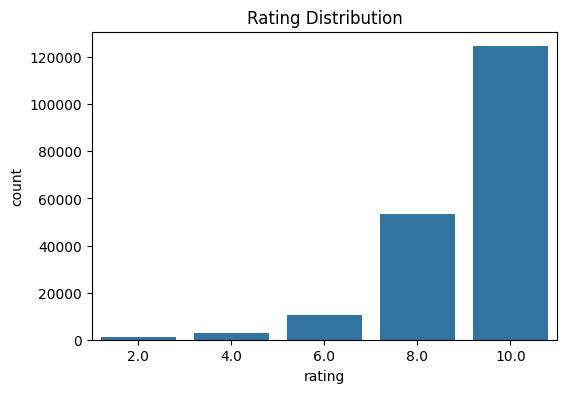

In [16]:
# -----------------------------
# Basic Statistics
# -----------------------------
print("Number of users:", df['user_id'].nunique())
print("Number of items:", df['item_id'].nunique())
print("Number of transactions:", len(df))

# Rating distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['rating'])
plt.title("Rating Distribution")
plt.show()

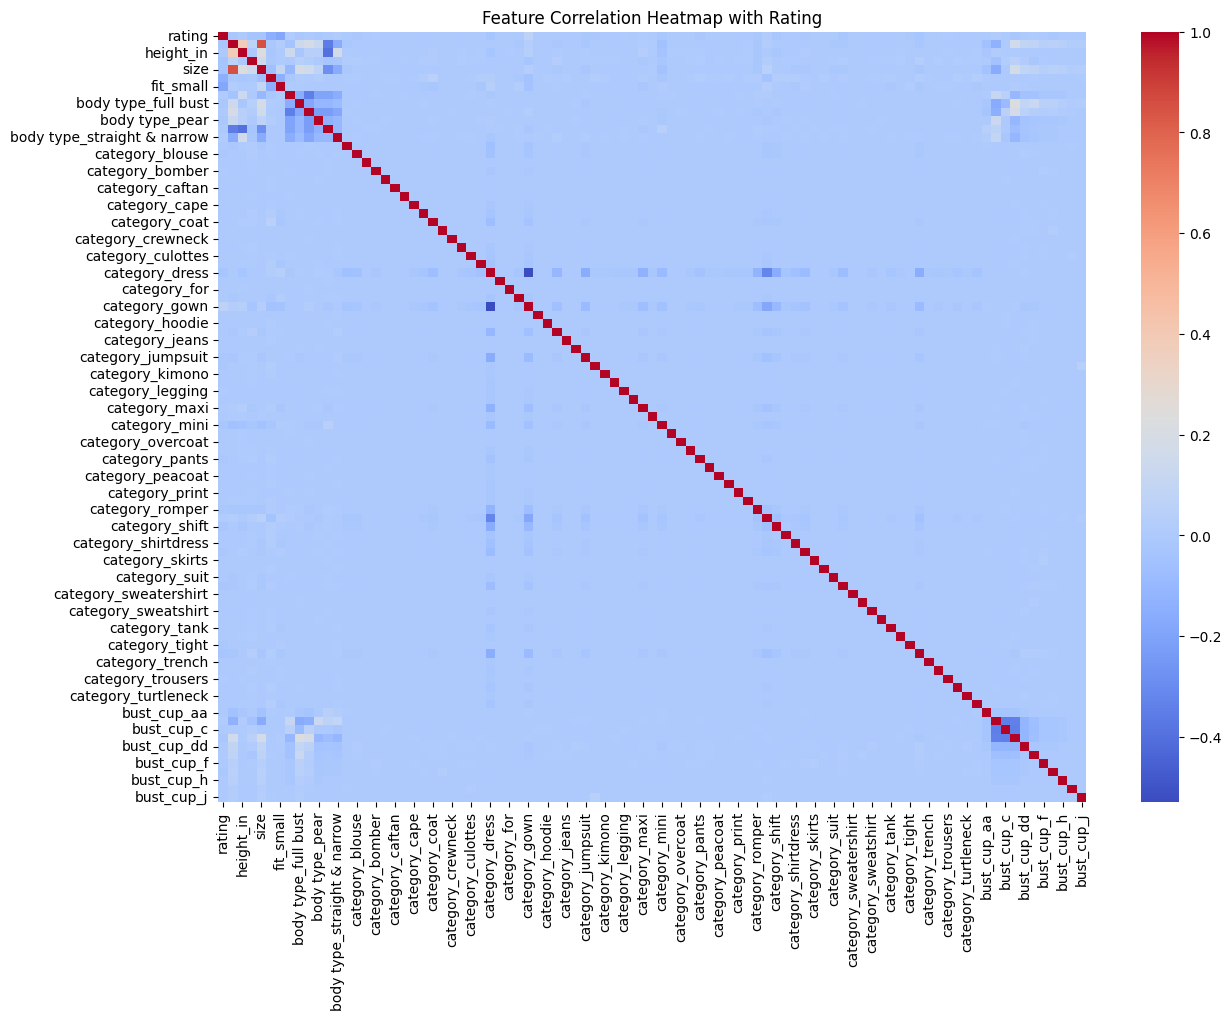

In [17]:
# -----------------------------
# Correlation Heatmap
# -----------------------------
# Select numeric columns + encoded categorical
num_df = df[['rating','weight_num','height_in','age','size']].copy()

# Add categorical encoding
cat_cols = ['fit','body type','category','bust_cup']
num_df = pd.concat([num_df, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)

corr = num_df.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap with Rating")
plt.show()

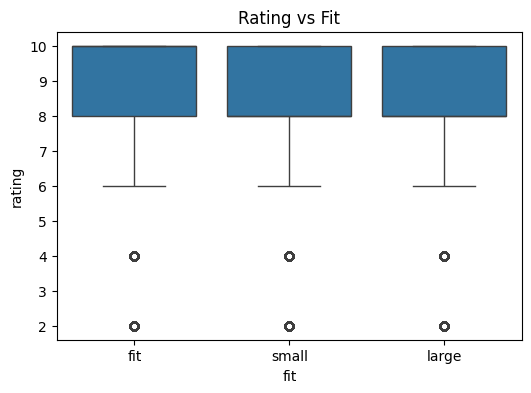

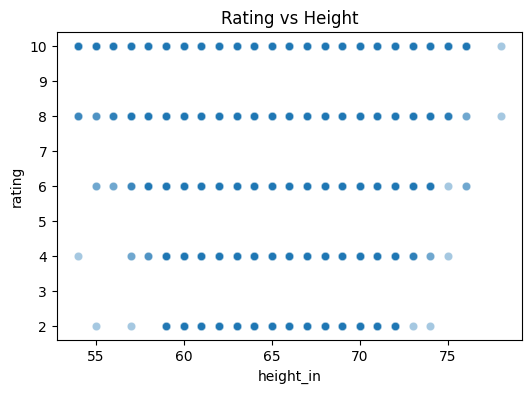

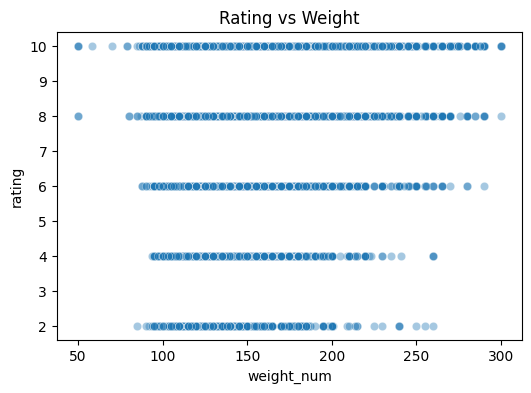

In [ ]:
# -----------------------------
# Relationship plots
# -----------------------------

plt.figure(figsize=(6,4))
sns.boxplot(x=df['fit'], y=df['rating'])
plt.title("Rating vs Fit")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=df['height_in'], y=df['rating'], alpha=0.4)
plt.title("Rating vs Height")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=df['weight_num'], y=df['rating'], alpha=0.4)
plt.title("Rating vs Weight")
plt.show()

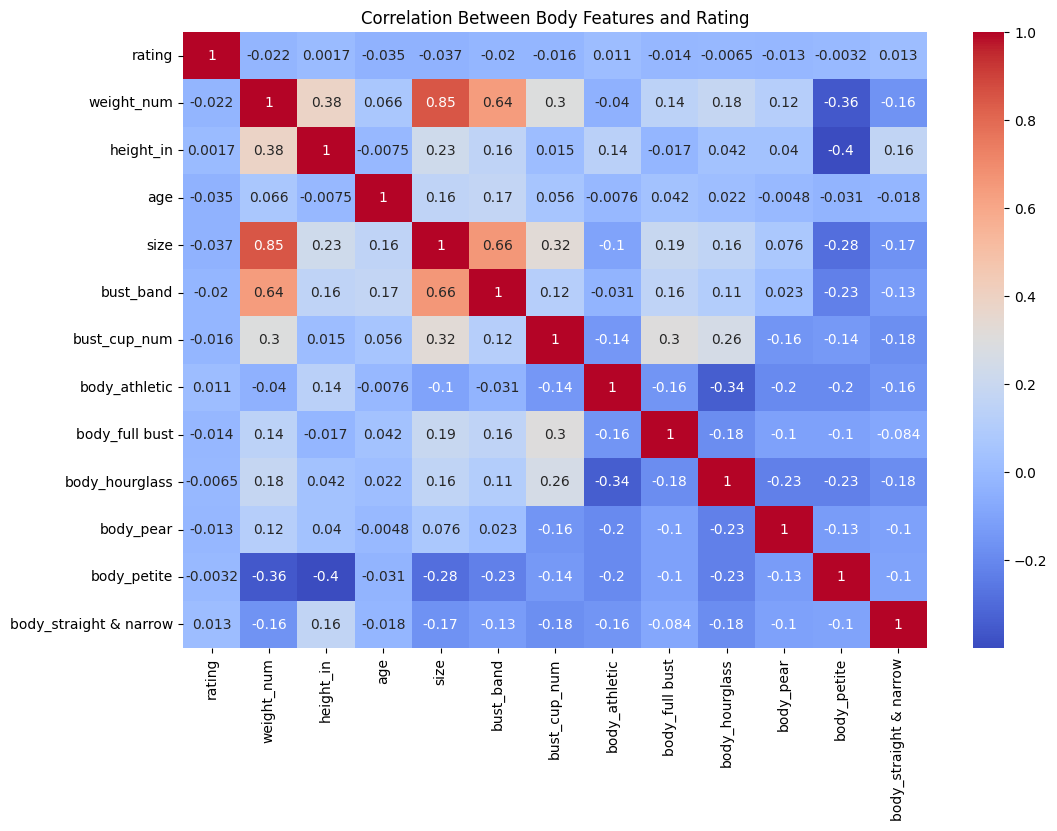

In [28]:
# Convert cup size to a numeric encoding
cup_map = {
    'aa': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'dd': 6,
    'ddd': 7, 'e': 8, 'f': 9, 'g': 10
}

df['bust_cup_num'] = df['bust_cup'].map(cup_map)

# One-hot encode body type
bodytype_dummies = pd.get_dummies(df['body type'], prefix='body', drop_first=True)

# Build correlation dataframe
corr_df = pd.concat([
    df[['rating', 'weight_num', 'height_in', 'age', 'size', 'bust_band', 'bust_cup_num']],
    bodytype_dummies
], axis=1)

# Compute correlation + heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Body Features and Rating")
plt.show()

In [ ]:
# -----------------------------
# Summary table for recommender system preparation
# -----------------------------
user_item_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating')
print(user_item_matrix.head())

item_id  1000254  1000270  1000739  1001122  1001783  1001785  1001829  \
user_id                                                                  
100011       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
100014       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
100033       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
100042       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
100043       NaN      NaN      NaN      NaN      NaN      NaN      NaN   

item_id  1001857  1002181  1002298  ...  994626  995232  995959  996851  \
user_id                             ...                                   
100011       NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN   
100014       NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN   
100033       NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN   
100042       NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN   
100043       NaN      NaN      

In [ ]:
#Look at each category's count of null values
df.isna().sum().sort_values(ascending=False)

,0
weight,29982
bust size,18411
body type,14637
age,960
height,677
rating,82
rented for,10
item_id,0
user_id,0
fit,0


In [ ]:
# Bust size is often empty. When there are values, what type of clothing is it for?
df[df['bust size'].notna()].category.unique()

array(['romper', 'gown', 'dress', 'sheath', 'leggings', 'top', 'sweater',
       'jacket', 'shirtdress', 'jumpsuit', 'maxi', 'shift', 'shirt',
       'mini', 'skirt', 'pants', 'blouse', 'suit', 'coat', 'trench',
       'bomber', 'cape', 'blazer', 'vest', 'duster', 'ballgown', 'tank',
       'poncho', 'frock', 'tunic', 'cardigan', 'culottes', 'down',
       'trouser', 'midi', 'pant', 'legging', 'print', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'kaftan', 'overalls', 'jogger', 'tee',
       'combo', 'henley', 'cami', 'blouson', 'pullover', 'turtleneck',
       'trousers', 'overcoat', 'hoodie', 't-shirt', 'caftan', 'tight',
       'kimono', 'for', 'crewneck', 'skirts', 'parka', 'buttondown',
       'skort', 'sweatershirt', 'sweatpants', 'jeans'], dtype=object)

In [ ]:
def h_to_in(h):
    if pd.isna(h):
        return np.nan
    # height is currently "5' 8\"" → split on the apostrophe
    feet, inches = h.split("'")
    feet = int(feet.strip())
    inches = int(inches.replace('"', '').strip())
    return feet * 12 + inches #make conversion to inches

In [ ]:
# Let's clean up some of the data
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['height'] = df['height'].apply(h_to_in)

In [ ]:
df[df['weight'].isnull()]

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,"December 14, 2015"
8,fit,166228,36d,1729232,NaN,10,formal affair,I was nervous of it looking cheap when it arri...,full bust,Great for black tie event!,gown,66.0,21,27.0,"June 27, 2016"
22,fit,871659,36c,2736018,NaN,10,work,Super cute; love the 3/4 length sleeves. With ...,pear,Wore to work,top,65.0,20,32.0,"March 16, 2017"
28,fit,205922,34b,149913,NaN,8,party,I wore this to a company holiday event and wan...,straight & narrow,So unique!,dress,69.0,8,34.0,"February 6, 2014"
32,fit,335467,NaN,2155094,NaN,10,date,I rented this for my birthday dinner at a down...,petite,"Love, love, love it!",jumpsuit,63.0,8,29.0,"November 3, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192514,small,449110,NaN,914136,NaN,8,wedding,This was a really fun dress for a fall wedding...,full bust,I felt trendy and cute!,dress,62.0,16,31.0,"November 10, 2016"
192515,fit,378332,34d,125465,NaN,10,wedding,This was my backup dress to a black tie weddin...,NaN,So Flowy and Fun!,gown,67.0,13,31.0,"June 10, 2016"
192517,fit,829883,36d,2842792,NaN,10,party,"I think it's got a great shape, the fabric dra...",full bust,"Love the top, lots of compliments",top,68.0,20,55.0,"September 4, 2017"
192527,fit,708552,34b,1697200,NaN,10,wedding,This dress was so beautiful and perfectly app...,hourglass,I was on Cloud Nine,dress,67.0,8,30.0,"August 28, 2014"


In [ ]:
# We should figure a clever way to impute weight
# First we need to remove lbs out of each weight category and make it numeric

# Remove 'lbs' and convert to numeric
df['weight'] = df['weight'].str.replace('lbs', '', regex=False)  # remove the string 'lbs'
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')     # convert to float

In [ ]:
"""
Group people by body type, height, and size. For each missing value in each
group, impute with the median.
"""
df['weight'] = df.groupby(['size', 'height', 'body type'])['weight'].transform(
    lambda x: x.fillna(x.median())
)
"""
Some groups had missing body type categories, so now we group by only height and
size. Then fill NaN with the median of those categories.
"""
df['weight'] = df.groupby(['size', 'height'])['weight'].transform(
    lambda x: x.fillna(x.median())
)

"""
There were still some missing values as height wasn't provided. However, all
entries provided size, so group by size and fill NaN with the median of each
size category.
"""
df['weight'] = df.groupby('size')['weight'].transform(
    lambda x: x.fillna(x.median())
    )

In [ ]:
"""
Bust size is also often left unmarked and could be a strong indicator if a user
would prefer an item from another user of a similar build. We can separate bust
into the cup and the band size. Band size is a measurement of the rib cage and could
align better with weight, height, and overall clothing size.
"""
# Extract numeric band
df['bust_band'] = df['bust size'].str.extract(r'(\d+)').astype(float)

# Extract cup letters (including extended like DDD/E, +, etc.)
df['bust_cup'] = df['bust size'].str.extract(r'([a-zA-Z\+\-/]+)')

In [ ]:
df['bust_band'] = df.groupby(['size', 'weight', 'height'])['bust_band'].transform(
    lambda x: x.fillna(x.median())
    )
df['bust_band'] = df.groupby(['size', 'weight'])['bust_band'].transform(
    lambda x: x.fillna(x.median())
    )
df['bust_band'] = df.groupby(['size'])['bust_band'].transform(
    lambda x: x.fillna(x.median())
    )
df['bust_band'] = df['bust_band'].fillna(df['bust_band'].median())

In [ ]:
# Most restrictive group
df['bust_cup'] = df.groupby(['size', 'weight', 'height'])['bust_cup'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
).infer_objects()

# Less restrictive group
df['bust_cup'] = df.groupby(['size', 'weight'])['bust_cup'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
).infer_objects()

# Broadest group
df['bust_cup'] = df.groupby(['size'])['bust_cup'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
).infer_objects()

/tmp/ipython-input-1190559731.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
/tmp/ipython-input-1190559731.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)


In [ ]:
df = df.drop(columns=['bust size'])

In [ ]:
df['body type'] = df.groupby(['size', 'bust_band','height'])['body type'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
).infer_objects()
df['body type'] = df.groupby(['size', 'bust_band'])['body type'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
).infer_objects()
df['body type'] = df.groupby(['size'])['body type'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
).infer_objects()

/tmp/ipython-input-3705845587.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
/tmp/ipython-input-3705845587.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)


In [ ]:
df.isna().sum().sort_values(ascending=False)

,0
age,960
height,677
rating,82
rented for,10
weight,0
item_id,0
fit,0
user_id,0
body type,0
review_text,0


In [ ]:
df[df['age'].isnull()]

,fit,user_id,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,bust_band,bust_cup
68,fit,245758,132738,145.0,8,party,"This dress is gorgeous, but the front is VERY ...",hourglass,I love RTR! I always feel amazing when I get a...,gown,65.0,16,NaN,"October 4, 2014",38.0,d+
655,fit,718564,1238932,143.0,10,wedding,The fit was outstanding. I love the peepshow ...,athletic,"Great color, and shows just enough skin!",dress,68.0,8,NaN,"November 28, 2017",34.0,a
768,small,83679,183194,170.0,4,party,"Too tight in the chest, had to pin it to keep ...",hourglass,"Cute dress, but too busty",dress,67.0,24,NaN,"June 9, 2014",36.0,dd
839,small,347742,862446,150.0,6,formal affair,This dress was beautiful! I am tall so this dr...,athletic,Really pretty dress! But not super comfortable.,gown,71.0,13,NaN,"October 9, 2017",34.0,c
1223,fit,481238,1714731,125.0,8,formal affair,"I normally wear a size 6, but was advised to o...",hourglass,"stunning, not typical formal dress for my prom!",gown,65.0,13,NaN,"August 28, 2016",36.0,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190570,large,125457,2767494,137.0,6,everyday,This is a nice piece but it's gigantic. Size down,hourglass,BIG,hoodie,63.0,14,NaN,"August 31, 2016",36.0,b
190720,fit,846050,2530612,140.0,10,party,"really great fit, flattering",athletic,bachelorette party,romper,64.0,8,NaN,"September 14, 2015",32.0,d
190864,small,144465,2877562,140.0,10,date,Wore this for a date night to a swanky little ...,hourglass,Loved this outfit!,gown,63.0,16,NaN,"July 31, 2015",32.0,d
191708,small,838877,1528722,110.0,10,work,"My measurements are 32, 23, 34 at 5'3"". I usua...",hourglass,Great cocktail dress!,dress,63.0,4,NaN,"August 24, 2016",32.0,b


In [ ]:
"""
Entries with age missing (960) are less than 1% of the total data. Imputing with median or mode
only adds inaccuracy rather than making the data more robust for training. There does not appear
to be a better way to deal with the missing data, so recommend dropping missing
age values.
"""
df = df[df['age'].notna()]

In [ ]:
"""
Height is also difficult to impute since size, weight, body type, and bust are more
correlated with width rather than vertical height. With less than 1% height entries missing
recommend dropping the rest.
"""
df = df[df['height'].notna()]

In [ ]:
"""
We should also drop the remaining missing entries for rating (81) and 'rented for'.
The missing entries are inconsequential to the overall dataset. Same goes
for 'rented for' missing values.
"""
df = df.dropna(subset=['rating', 'rented for'])

In [ ]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

Start building recommender system

In [ ]:
"""
We begin by creating a pivot table so that we can feed this into our classical
SVD decomposition to pull out the important latent factors.
A=U∑V^T. Unfortunately, buidling a pivot table consumes a lot of memory.
We can try to use a memory-efficient pipeline using 'implicit' to build the
sparse user-item and rating matrix and training an Alternating Least Squares
model.
"""

"\nWe begin by creating a pivot table so that we can feed this into our classical\nSVD decomposition to pull out the important latent factors.\nA=U∑V^T. Unfortunately, buidling a pivot table consumes a lot of memory. \nWe can try to use a memory-efficient pipeline using 'implicit' to build the\nsparse user-item and rating matrix and training an Alternating Least Squares\nmodel.\n"

In [ ]:
"""
Running: A = A.fillna(0) creates a full dense copy which breaches threshold of
Google colab system RAM. Need to convert pivot table to a sparse matrix instead.
Spare matrix only stores non-zero entries.
"""
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.model_selection import train_test_split

In [ ]:
#Retreive the unique user IDs and unique item IDs
user_ids = df['user_id'].unique()
item_ids = df['item_id'].unique()

#Map the unique user IDs and item IDs to an eunumerated dictionary
user_map = {uid: i for i, uid in enumerate(user_ids)}
item_map = {iid: i for i, iid in enumerate(item_ids)}

#Add columns to our df with the user_idx and item_idx
df['user_idx'] = df['user_id'].map(user_map)
df['item_idx'] = df['item_id'].map(item_map)

In [ ]:
#Create a train/val (80%) set and a test set (20%)
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=7)

#Of the train/val set, split it into 75% validation and 25% training
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=7)

In [ ]:
# COO format (efficient for construction)
train_sparse = coo_matrix(
    (train_df['rating'].values, (train_df['user_idx'], train_df['item_idx'])),
    shape=(len(user_ids), len(item_ids))
).tocsr()

In [ ]:
val_sparse = coo_matrix(
    (val_df['rating'].values, (val_df['user_idx'], val_df['item_idx'])),
    shape=(len(user_ids), len(item_ids))
).tocsr()

In [ ]:
K_vals =[10,20,50,100,200]

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

In [ ]:
results = []
for K in K_vals:
    # Train SVD on train_sparse
    svd = TruncatedSVD(n_components=K, random_state=7)
    user_embeddings = svd.fit_transform(train_sparse)  # (num_users, K)
    item_embeddings = svd.components_.T               # (num_items, K)

    # Predict ratings for validation set
    val_preds = np.array([
        user_embeddings[u] @ item_embeddings[i]
        for u, i in zip(val_df['user_idx'], val_df['item_idx'])
    ])

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(val_df['rating'].values, val_preds))
    print(f"K={K}, Validation RMSE={rmse:.4f}")

    results.append((K, rmse))

K=10, Validation RMSE=9.2086
K=20, Validation RMSE=9.2084
K=50, Validation RMSE=9.2049
K=100, Validation RMSE=9.2037
K=200, Validation RMSE=9.1995
